### 5. Сегментация изображений

Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ<br>
Обучить модель на выбор из segmentation_models_pytorch<br>
У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/nWMoBVgvWYcI7g

In [1]:
!pip install segmentation_models_pytorch

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from pathlib import Path
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchsummary import summary
import torch.nn as nn
import segmentation_models_pytorch as smp
import time
from PIL import Image
from keras.applications.vgg16 import preprocess_input

Загрузим данные и посмотрим на них

In [4]:
df = pd.read_csv('list.csv', delimiter=',')

df.dataframeName = 'list.csv'

In [5]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [8]:
path_image = "720p"
path_mask = "mask"
labels = ['NoLips','Lips']

(720, 1280, 3)


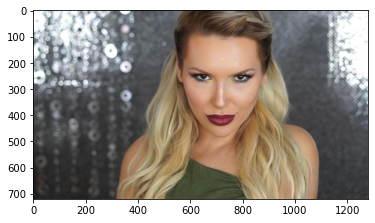

In [11]:

img=plt.imread('720p/image00000001.jpg')
print(img.shape)
plt.imshow(img)


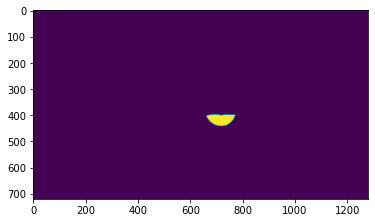

In [12]:
img = plt.imread('mask/mask00000001.png')
plt.imshow(img[..., 1])

In [13]:
images = []

for root, dirs, files in os.walk(path_image):
    for name in files:
        f = os.path.join(root, name)
        if 'image' in f:
            images.append(f)
        else:
            break

masks = []

for root, dirs, files in os.walk(path_mask):
    for name in files:
        f = os.path.join(root, name)
        if 'mask' in f:
            masks.append(f)
        else:
            break

In [14]:
len(images), len(masks), images[-1], masks[-1]

(28594, 28540, '720p\\image00028594.jpg', 'mask\\mask00028594.png')

Количество картинок не совпадает с количеством масок. Уберем лишние картинки

In [30]:
images_w_mask = []
#cnt_num = 1

for img in images:
#    if (cnt_num % 1000) == 0:
#        print('cnt_num=', cnt_num)
#    cnt_num += 1
    for mask in masks:
        if img[-12:-4] == mask[-12:-4]:
            images_w_mask.append(img)
            break
#print('images_w_mask=', len(images_w_mask))
masks_adapt = []
cnt_num = 1

for img in images_w_mask:
#    if (cnt_num % 1000) == 0:
#        print('cnt_num=', cnt_num)
#    cnt_num += 1
    masks_adapt.append(f"mask/mask{img[-12:-4]}.png")

In [31]:
len(images_w_mask), len(masks_adapt), images_w_mask[-1], masks_adapt[-1]

(28540, 28540, '720p\\image00028594.jpg', 'mask/mask00028594.png')

In [32]:
df = pd.DataFrame({'images': images_w_mask, 'masks': masks_adapt})
df.sort_values(by='images', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,images,masks
0,720p\image00000001.jpg,mask/mask00000001.png
1,720p\image00000002.jpg,mask/mask00000002.png
2,720p\image00000003.jpg,mask/mask00000003.png
3,720p\image00000004.jpg,mask/mask00000004.png
4,720p\image00000005.jpg,mask/mask00000005.png


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  28540 non-null  object
 1   masks   28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [34]:
img = np.asarray(Image.open(images_w_mask[0])).astype('float')
img.shape

(720, 1280, 3)

Преобразуем данные в тензор заданного размера

In [35]:
img = torch.as_tensor(img)/255
img = img.unsqueeze(0)
print(img.shape)
img = img.permute(0,3,1,2)
print(img.shape)
img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
print(img.shape)

torch.Size([1, 720, 1280, 3])
torch.Size([1, 3, 720, 1280])
torch.Size([1, 3, 256, 256])


In [36]:
mask_it = np.asarray(Image.open(masks_adapt[-1])).astype('int')
mask_it.shape

(720, 1280, 3)

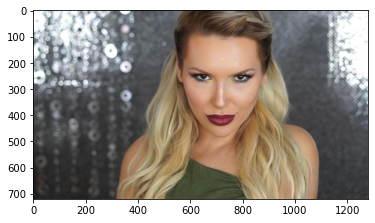

In [37]:
plt.imshow(Image.open(images_w_mask[0]))

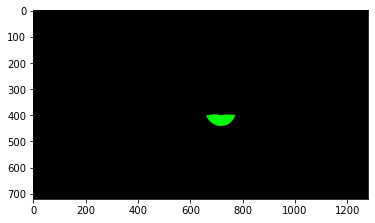

In [38]:
plt.imshow(Image.open(masks_adapt[0]))

Сформируем кастомный датасет для обучения сети и разобъем его на тренировочную и тестовую выборки, обернем в Dataloader

In [40]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        self.data_info = data_info
        self.image_arr = self.data_info.iloc[:,0]
        self.label_arr = self.data_info.iloc[:,1]
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        img = torch.as_tensor(img)/255    
        img = img.unsqueeze(0).permute(0,3,1,2)
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,1]
        f_lp = torch.as_tensor(np.where(lab<0.4, 255, 0)).unsqueeze(0)
        t_lp = torch.as_tensor(np.where(lab>=0.4, 255, 0)).unsqueeze(0)
        t_lp = torch.cat((t_lp, f_lp), dim=0).unsqueeze(0)
        lab = F.interpolate(input=t_lp.float(), size=256, mode='nearest')
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len
    
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)
        score =(2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score =1 - score.sum() / num
        return score
    
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None
        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target

In [41]:
X_data, X_test = train_test_split(df, test_size=0.23)

X_train, X_valid = train_test_split(X_data, test_size=0.23)

X_train.reset_index(drop=True,inplace=True)
X_valid.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

train_data = CustomDatasetFromImages(X_train[:30])
valid_data = CustomDatasetFromImages(X_valid[:30])
test_data = CustomDatasetFromImages(X_test)

batch_s = 3

train_data_loader = DataLoader(train_data, batch_size=batch_s, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=batch_s, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)

Инициализируем устройство, на котором будем обучать модель

In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Инициализируем U-net с предобученным энкодером resnet34

In [44]:
learning_rate = 0.001

epochs = 5
segmodel = smp.Unet('resnet34', classes=2, activation='softmax').to(device)
optimizer = torch.optim.Adam(segmodel.parameters())
criterion = SoftDiceLoss()
path_checkpoint = "checkpoints_lp"
if not os.path.exists(path_checkpoint):
    os.mkdir(path_checkpoint)

In [45]:
print(segmodel)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Заморозим веса энкодера

In [46]:
for param in list(segmodel.encoder.parameters())[:]:
    param.requires_grad = False

In [47]:
summary(segmodel.to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

C:\Users\Инна\AppData\Roaming\Python\Python39\site-packages\segmentation_models_pytorch\base\modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


In [49]:
import segmentation_models_pytorch.utils.metrics

criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

params_to_update = []
for name, param in segmodel.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [50]:
#цикл перебора образцов загрузчика данных
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [52]:
epoch_losses = []

epoch_val_losses = []

In [53]:
for epoch in range(epochs):  
    running_loss = 0.0
    cum_loss = []

    print(f'Epoch: {epoch+1}')
    time1 = time.time()
    segmodel.train()
    for i, data in enumerate(train_data_loader, 0):
        
        inputs, labels = data
        inputs = inputs.to(device) 
        labels = labels.to(device) 

        optimizer.zero_grad()

        outputs = segmodel(inputs[0])
        loss = criterion(outputs, labels[0,:,:,:])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        cum_loss.append(loss.item())
        if not (i+1) % 10:   
            print(f'\tbatchcount: {i+1}, avg. loss for last {batch_s*10} images: {running_loss/(batch_s*10):.5f}')
            running_loss = 0.0

    time2 = time.time()
    epoch_losses.append(np.mean(cum_loss))
    torch.save(segmodel.state_dict(), path_checkpoint + f"/checkpoint_lp_ep_{epoch+1}.pth")

    cum_loss = []
    segmodel.eval()
    with torch.no_grad():
        running_val_loss = 0.0
        for i, data in enumerate(valid_data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device) 
            labels = labels.to(device) 

            outputs = segmodel(inputs[0])
            loss = criterion(outputs, labels[0,:,:,:])

            running_val_loss += loss.item()
            cum_loss.append(loss.item())

    epoch_val_losses.append(np.mean(cum_loss))
    print(f'\n  Epoch {epoch+1}, loss: {epoch_losses[-1]:.5f} loss_val: {epoch_val_losses[-1]:.5f} time = {time2-time1:.2f} sec\n')

Epoch: 1
	batchcount: 10, avg. loss for last 30 images: -0.09955

  Epoch 1, loss: -0.29864 loss_val: -0.73103 time = 15.11 sec

Epoch: 2
	batchcount: 10, avg. loss for last 30 images: -0.24016

  Epoch 2, loss: -0.72048 loss_val: -0.83550 time = 13.55 sec

Epoch: 3
	batchcount: 10, avg. loss for last 30 images: -0.28707

  Epoch 3, loss: -0.86120 loss_val: -0.90887 time = 13.71 sec

Epoch: 4
	batchcount: 10, avg. loss for last 30 images: -0.30740

  Epoch 4, loss: -0.92219 loss_val: -0.93982 time = 14.11 sec

Epoch: 5
	batchcount: 10, avg. loss for last 30 images: -0.31370

  Epoch 5, loss: -0.94110 loss_val: -0.95801 time = 13.84 sec



Сделаем предсказание

In [56]:
net_out = smp.Unet('resnet34', classes=2, activation='softmax').to(device)
net_out.load_state_dict(torch.load(path_checkpoint + f"/checkpoint_lp_ep_5.pth"))

<All keys matched successfully>

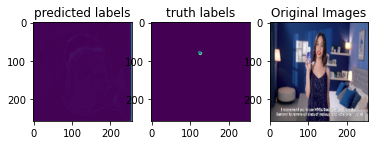

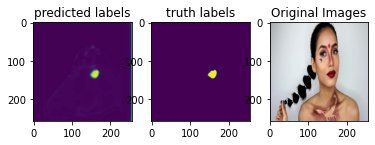

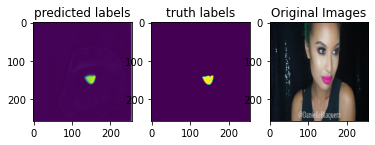

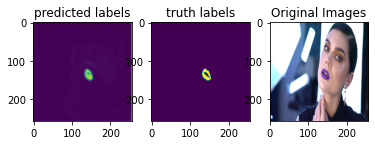

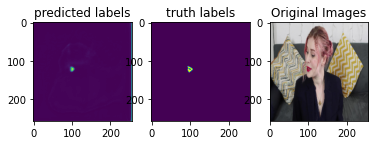

In [60]:
for i, data in enumerate(valid_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net_out(images[0])
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[0,:,:])
    axarr[0].set_title('predicted labels')    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('truth labels')  
    original = images[0][0,:,:,:].cpu()
    original = original.permute(1, 2, 0)
    original = original.numpy()
    original = np.clip(original, 0, 1)
    axarr[2].imshow(original)
    axarr[2].set_title('Original Images')
    plt.show()
    
    if i>3:
        break